In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys


# Plot Results

This notebook can be used to create plots for the results. It requires the results to be present inside `../results/benchmark_results.csv`.

In [26]:
# -------------------------------
# 📥 CSV laden
# -------------------------------

CSV_PATH = "../results/benchmark_results.csv"

if not os.path.exists(CSV_PATH):
    print(f"❌ CSV-Datei nicht gefunden unter: {CSV_PATH}")
    sys.exit(1)

df = pd.read_csv(CSV_PATH)

# -------------------------------
# 🧹 Daten aufbereiten
# -------------------------------

numeric_cols = [
    "pixels", "nf", "nt", "repeats", "median_time", "std_time",
    "median_chisq"
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

df = df.sort_values(by=["algorithm", "pixels", "nt"]).reset_index(drop=True)

# -------------------------------
# ⚡ Speedup automatisch berechnen
# -------------------------------
# CPU-Zeiten extrahieren
cpu_times = df[df["algorithm"] == "cpu"][["pixels", "nt", "median_time"]]
cpu_times = cpu_times.rename(columns={"median_time": "cpu_time"})

# Mit Originaldaten mergen
df = df.merge(cpu_times, on=["pixels", "nt"], how="left")

# Speedup berechnen (nur wenn cpu_time existiert)
df["speedup_vs_cpu"] = df["cpu_time"] / df["median_time"]

# -------------------------------
# 📊 Erste Übersicht ausgeben
# -------------------------------

print("✅ CSV erfolgreich geladen!")
print(f"📁 Datensätze: {len(df)}\n")

print("🔎 Verfügbare Algorithmen:")
print(df["algorithm"].unique(), "\n")

print("📏 Pixelwerte:")
print(df["pixels"].unique(), "\n")

print("🌡️ Temperatur-Bins (nt):")
print(df["nt"].unique(), "\n")

print("📊 Alle Datensätze:")
print(df)

✅ CSV erfolgreich geladen!
📁 Datensätze: 24

🔎 Verfügbare Algorithmen:
['cpu' 'gpu-l2' 'vectorized'] 

📏 Pixelwerte:
[ 200 1000 2000 5000] 

🌡️ Temperatur-Bins (nt):
[200 400] 

📊 Alle Datensätze:
     algorithm  pixels  nf   nt  repeats  median_time  std_time  median_chisq  \
0          cpu     200   6  200        2     3.686069  0.009787      0.238236   
1          cpu     200   6  400        2    17.064837  0.021823      0.329806   
2          cpu    1000   6  200        2     4.226081  0.006473      0.324331   
3          cpu    1000   6  400        2    18.266336  0.079807      0.344501   
4          cpu    2000   6  200        2     4.955185  0.011228      0.320744   
5          cpu    2000   6  400        2    20.694898  0.304331      0.328788   
6          cpu    5000   6  200        2     7.091193  0.050497      0.297519   
7          cpu    5000   6  400        2    38.916675  1.885887      0.360490   
8       gpu-l2     200   6  200        2     0.003945  0.000124     25.816

In [35]:
# -------------------------------
# 💡 Plot Style
# -------------------------------

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (12, 5)
OUTDIR = "../results/plots"
os.makedirs(OUTDIR, exist_ok=True)

# -------------------------------
# 📊 Hilfsfunktion: Plots für einen Algorithmus erzeugen
# -------------------------------

def plot_algorithm_performance(df: pd.DataFrame, algorithm: str):
    dfa = df[df["algorithm"] == algorithm].sort_values(by=["pixels", "nt"])
    if dfa.empty:
        print(f"⚠️ Keine Daten für Algorithmus '{algorithm}' gefunden.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 1️⃣ Laufzeit vs. Pixelanzahl
    sns.lineplot(
        data=dfa,
        x="pixels",
        y="median_time",
        marker="o",
        ax=axes[0],
        errorbar=None,
    )
    axes[0].set_title(f"Laufzeit vs. Pixelanzahl for {algorithm}")
    axes[0].set_xlabel("Number of Pixel")
    axes[0].set_ylabel("Median Runtime [s]")

    # 2️⃣ Speedup vs. Pixelanzahl
    if "speedup_vs_cpu" in dfa.columns:
        sns.lineplot(
            data=dfa,
            x="pixels",
            y="speedup_vs_cpu",
            marker="o",
            ax=axes[1],
            errorbar=None,
        )
        axes[1].set_title(f"⚡ Speedup vs. CPU for {algorithm}")
        axes[1].set_xlabel("Number of Pixel")
        axes[1].set_ylabel("Speedup (×)")
    else:
        axes[1].text(
            0.5, 0.5,
            "⚠️ no speedup",
            ha="center", va="center", fontsize=12
        )
        axes[1].set_axis_off()

    plt.suptitle(f"Performance of {algorithm}", fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    out_path = os.path.join(OUTDIR, f"{algorithm}_performance.png")
    plt.savefig(out_path, dpi=200)
    plt.show(fig)
    print(f"✅ Plot für {algorithm} gespeichert: {out_path}")

📊 Erstelle Plots für folgende Algorithmen: ['cpu' 'gpu-l2' 'vectorized']


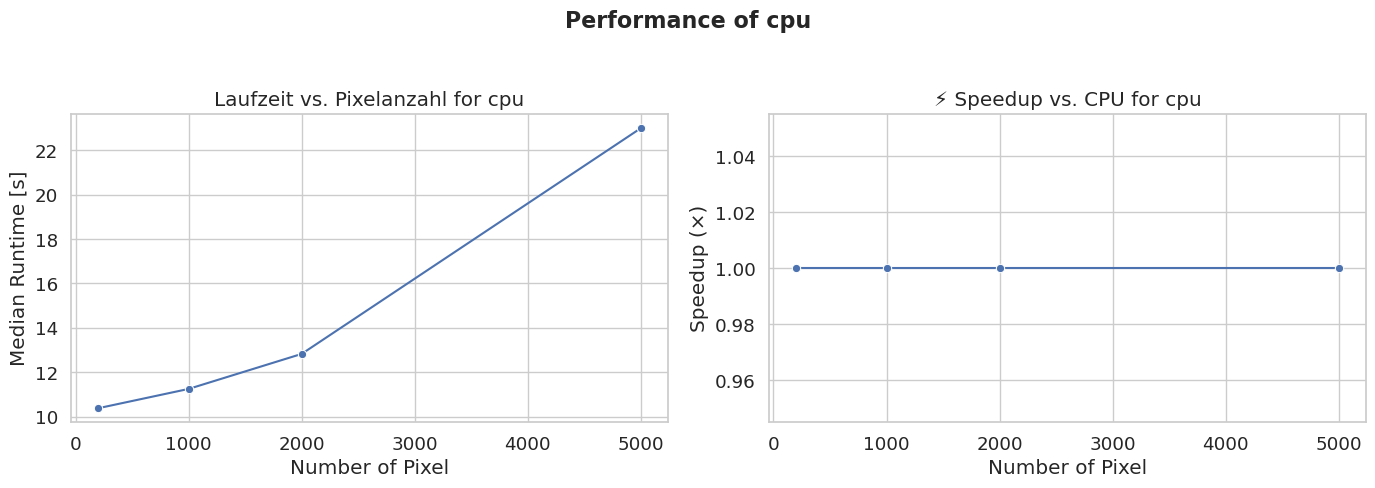

✅ Plot für cpu gespeichert: ../results/plots/cpu_performance.png


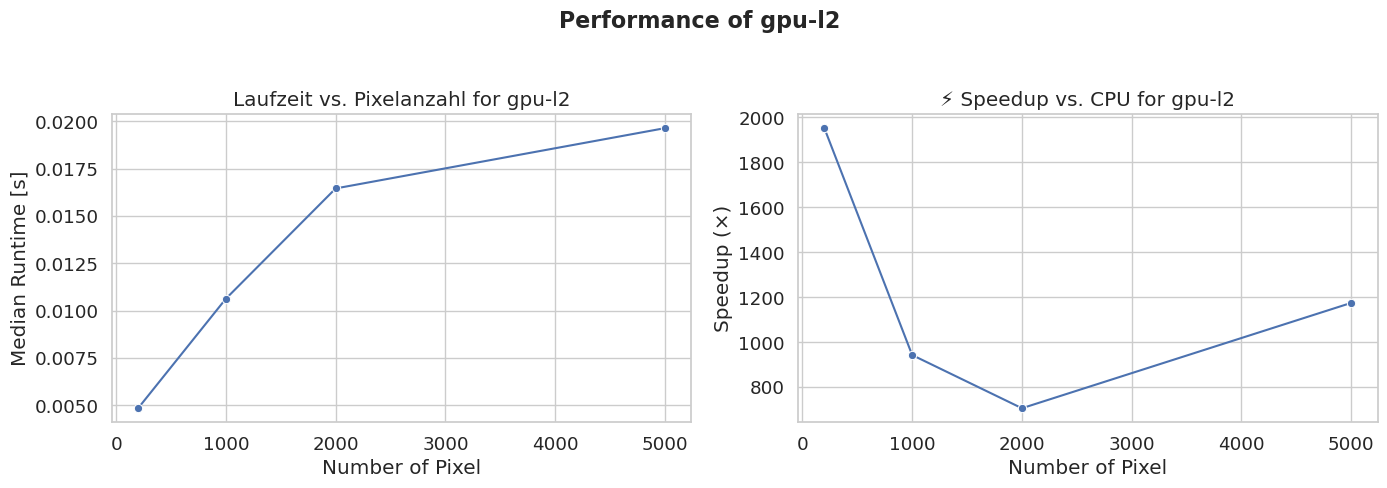

✅ Plot für gpu-l2 gespeichert: ../results/plots/gpu-l2_performance.png


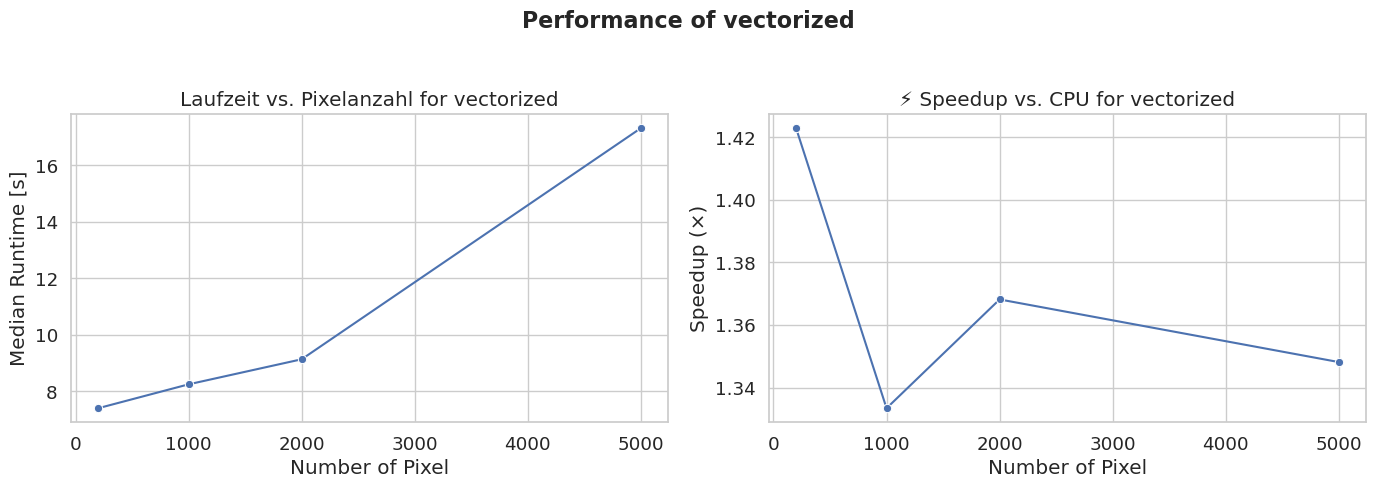

✅ Plot für vectorized gespeichert: ../results/plots/vectorized_performance.png


In [36]:
algos = df["algorithm"].unique()
print("📊 Erstelle Plots für folgende Algorithmen:", algos)
for algo in algos:
    plot_algorithm_performance(df, algo)